<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/04_pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)


There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))



1.   Get all of the image paths using *pathlib.Path.glob()* to find all of the files ending in .jpg.
2.   Pick a random image path using Python's *random.choice()*.
3.   Get the image class name using *pathlib.Path.parent.stem*.
4.   And since we're working with images, we'll open the random image path using *PIL.Image.open()* (PIL stands for Python Image Library).
5.    We'll then show the image and print some metadata.


Random image path: data/pizza_steak_sushi/test/pizza/930553.jpg
Image class: pizza
Image height: 512
Image width: 306


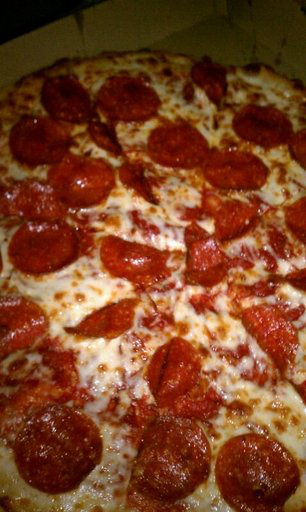

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

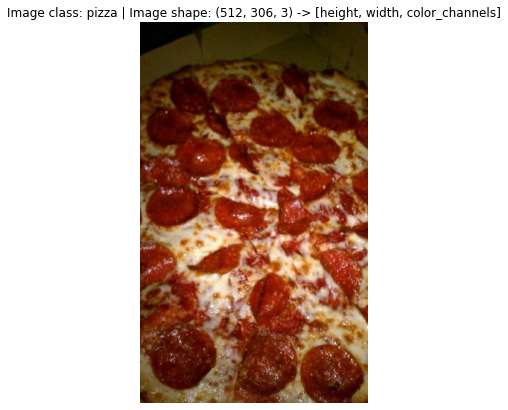

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Data transformation

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

* Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
* Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
* Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

In [9]:
data_transform = transforms.Compose([
    #resize
    transforms.Resize(size = (64,64)),
    #random flip
    transforms.RandomHorizontalFlip(p=0.5),
    #turn to tensor
    transforms.ToTensor(),
])

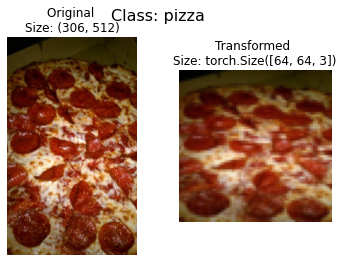

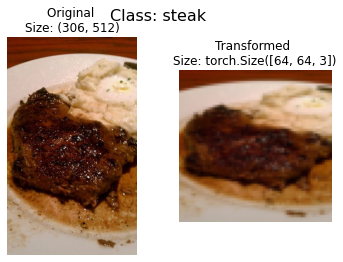

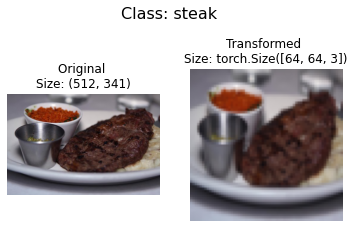

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths."""
    
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

## (option1) Loading Image Data Using ImageFolder

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform = None
                                  )
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform
                                  )

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")



Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data), len(test_data)


(225, 75)

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


(-0.5, 63.5, 63.5, -0.5)

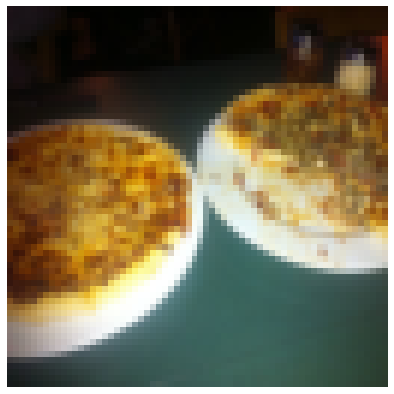

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")

In [17]:
os.cpu_count()

2

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size =1 ,
                              num_workers = 1, 
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size =1 , 
                              num_workers = 1, 
                              shuffle = False)

In [19]:
img,label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## (Option2) Loading Image Data with Custom Dataset

We'll start by importing the modules we need:

* Python's os for dealing with directories (our data is stored in directories).
* Python's pathlib for dealing with filepaths (each of our images has a unique filepath).
* torch for all things PyTorch.
* PIL's Image class for loading images.
* torch.utils.data.Dataset to subclass and create our own custom Dataset.
* torchvision.transforms to turn our images into tensors.

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [22]:
def find_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
   # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [23]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,target_dir:str,transform=None) -> None:
      super().__init__()
      #get image paths
      self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))#png or jped or jpg
      self.transform = transform
      self.classes,self.class_to_idx=find_classes(target_dir)
  
  def load_image(self,index:int)->Image.Image:
      image_path = self.paths[index]
      return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index:int) -> Tuple[torch.Tensor,int]:
     img = self.load_image(index)
     class_name = self.paths[index].parent.name
     class_idx = self.class_to_idx[class_name]

     if self.transform:
       return self.transform(img),class_idx
     else:
       return img,class_idx

In [25]:
#augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
#dont augment on test data

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [26]:
train_data_custom = ImageFolderCustom(target_dir = train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(target_dir = test_dir,
                                      transform=test_transforms)

train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7fbde329b6d0>,
 <__main__.ImageFolderCustom at 0x7fbde329bb50>)

In [27]:
len(train_data_custom),len(test_data_custom)#__len__ called

(225, 75)

In [28]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [29]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [31]:
def display_random_images(dataset,classes,n=10,display_shape:bool = True,seed:int = None):
  if n>10:
    n=10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

    
  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
      targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

      targ_image_adjust = targ_image.permute(1, 2, 0)#change dim order

      plt.subplot(1, n, i+1)
      plt.imshow(targ_image_adjust)
      plt.axis("off")
      if classes:
          title = f"class: {classes[targ_label]}"
          if display_shape:
              title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)
                
  


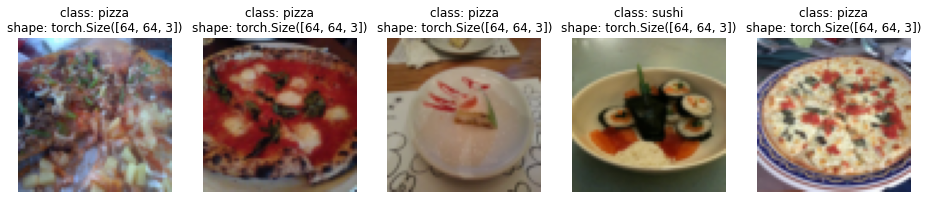

In [32]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


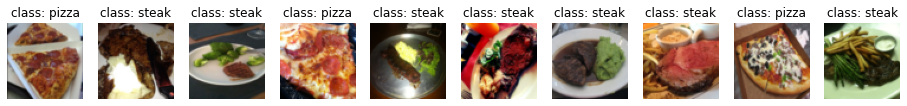

In [33]:
display_random_images(train_data_custom,n=12,classes = class_names,seed=42)

In [34]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(train_data_custom,
                                     batch_size = 1,
                                     shuffle=True,
                                     num_workers=0)

test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size = 1,
                                    shuffle=False,
                                    num_workers=0)

In [35]:
img_custom,label_custom = next(iter(train_dataloader_custom))

img_custom.shape,label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Transformation (Data Augmentation)

In [36]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

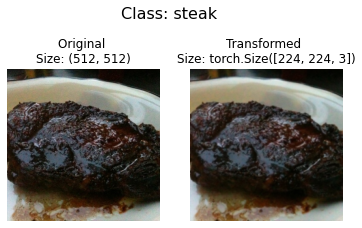

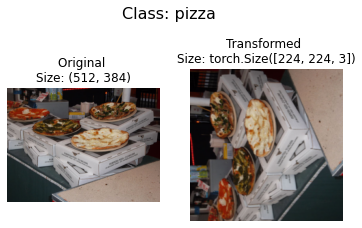

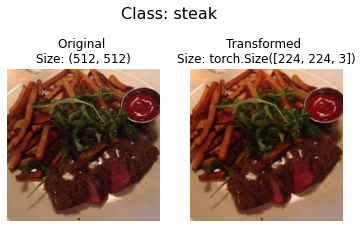

In [37]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Model without data augmentation


In [38]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [39]:
from torchvision import datasets
train_data_simple =  datasets.ImageFolder(root = train_dir,transform = simple_transform)
test_data_simple =  datasets.ImageFolder(root = test_dir,transform = simple_transform)

import os 
from torch.utils.data import DataLoader

train_dataloader_simple =  DataLoader(train_data_simple,
                                      batch_size = 32,
                                      num_workers = os.cpu_count(),
                                      shuffle = True)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=32, 
                                    shuffle=False, 
                                    num_workers=os.cpu_count())

In [40]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
       return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [41]:
img,label = next(iter(train_dataloader_simple))

X,y = img[0].unsqueeze(dim=0),label[0]

model_0.eval()
with torch.inference_mode():
  logit = model_0(X.to(device))
  pred = torch.softmax(logit,dim=1).argmax(dim=1)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{logit}\n")
print(f"Output prediction probabilities:\n{torch.softmax(logit, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(logit, dim=1), dim=1)}\n")
print(f"Actual label:\n{y}")

Output logits:
tensor([[0.0578, 0.0634, 0.0352]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [42]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size = [1,3,64,64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## train&test loop functions

In [43]:
from tqdm import tqdm
def train_step(model,dataloader,loss_fn,optimizer):
  model.train()

  train_loss,train_acc = 0,0

  for batch,(X,y) in enumerate(dataloader):
    X=X.to(device)
    y=y.to(device)

    #forward
    y_logit = model(X)

    #loss
    loss = loss_fn(y_logit,y)
    train_loss += loss.item()

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # accuracy
    y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)
    train_acc += (y_pred == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model,dataloader,loss_fn):
  model.eval()

  test_loss,test_acc = 0,0
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X=X.to(device)
      y=y.to(device)

      #forward
      y_logit = model(X)

      #loss
      loss = loss_fn(y_logit,y)
      test_loss += loss.item()
      
      #accuracy
      test_pred_labels = y_logit.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,):
  
  results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
  
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model,train_dataloader,loss_fn,optimizer)
      test_loss, test_acc = test_step(model,test_dataloader,loss_fn)
      print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
      
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
  return results


In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 25

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

#loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=num_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  4%|▍         | 1/25 [00:02<01:01,  2.55s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604


  8%|▊         | 2/25 [00:03<00:43,  1.88s/it]

Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979


 12%|█▏        | 3/25 [00:05<00:36,  1.66s/it]

Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1697 | test_acc: 0.1979


 16%|█▌        | 4/25 [00:06<00:32,  1.55s/it]

Epoch: 4 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1385 | test_acc: 0.1979


 20%|██        | 5/25 [00:08<00:29,  1.49s/it]

Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1428 | test_acc: 0.1979


 24%|██▍       | 6/25 [00:09<00:28,  1.50s/it]

Epoch: 6 | train_loss: 1.0956 | train_acc: 0.2500 | test_loss: 1.1463 | test_acc: 0.2604


 28%|██▊       | 7/25 [00:11<00:26,  1.47s/it]

Epoch: 7 | train_loss: 1.1188 | train_acc: 0.3047 | test_loss: 1.1418 | test_acc: 0.2708


 32%|███▏      | 8/25 [00:12<00:24,  1.45s/it]

Epoch: 8 | train_loss: 1.1039 | train_acc: 0.3438 | test_loss: 1.1099 | test_acc: 0.1979


 36%|███▌      | 9/25 [00:14<00:28,  1.78s/it]

Epoch: 9 | train_loss: 1.0960 | train_acc: 0.4375 | test_loss: 1.0917 | test_acc: 0.5417


 40%|████      | 10/25 [00:17<00:30,  2.02s/it]

Epoch: 10 | train_loss: 1.0900 | train_acc: 0.4023 | test_loss: 1.0744 | test_acc: 0.5417


 44%|████▍     | 11/25 [00:20<00:31,  2.25s/it]

Epoch: 11 | train_loss: 1.0738 | train_acc: 0.4102 | test_loss: 1.0520 | test_acc: 0.5729


 48%|████▊     | 12/25 [00:22<00:30,  2.35s/it]

Epoch: 12 | train_loss: 1.1499 | train_acc: 0.3594 | test_loss: 1.0286 | test_acc: 0.5938


 52%|█████▏    | 13/25 [00:25<00:28,  2.40s/it]

Epoch: 13 | train_loss: 1.0544 | train_acc: 0.4766 | test_loss: 1.0568 | test_acc: 0.5938


 56%|█████▌    | 14/25 [00:27<00:26,  2.37s/it]

Epoch: 14 | train_loss: 1.0610 | train_acc: 0.3516 | test_loss: 1.0494 | test_acc: 0.5047


 60%|██████    | 15/25 [00:29<00:22,  2.28s/it]

Epoch: 15 | train_loss: 1.0165 | train_acc: 0.6328 | test_loss: 1.0325 | test_acc: 0.4034


 64%|██████▍   | 16/25 [00:31<00:18,  2.01s/it]

Epoch: 16 | train_loss: 0.8445 | train_acc: 0.6250 | test_loss: 1.1170 | test_acc: 0.3523


 68%|██████▊   | 17/25 [00:32<00:14,  1.82s/it]

Epoch: 17 | train_loss: 0.9162 | train_acc: 0.6328 | test_loss: 1.0266 | test_acc: 0.3419


 72%|███████▏  | 18/25 [00:33<00:11,  1.69s/it]

Epoch: 18 | train_loss: 0.9140 | train_acc: 0.5430 | test_loss: 1.0372 | test_acc: 0.3826


 76%|███████▌  | 19/25 [00:35<00:09,  1.60s/it]

Epoch: 19 | train_loss: 0.8653 | train_acc: 0.5469 | test_loss: 1.0112 | test_acc: 0.5455


 80%|████████  | 20/25 [00:36<00:07,  1.53s/it]

Epoch: 20 | train_loss: 1.1005 | train_acc: 0.5469 | test_loss: 0.9939 | test_acc: 0.5047


 84%|████████▍ | 21/25 [00:38<00:05,  1.49s/it]

Epoch: 21 | train_loss: 0.7948 | train_acc: 0.6875 | test_loss: 1.0129 | test_acc: 0.3627


 88%|████████▊ | 22/25 [00:39<00:04,  1.46s/it]

Epoch: 22 | train_loss: 0.8412 | train_acc: 0.6211 | test_loss: 1.0251 | test_acc: 0.3627


 92%|█████████▏| 23/25 [00:40<00:02,  1.43s/it]

Epoch: 23 | train_loss: 0.7979 | train_acc: 0.5586 | test_loss: 1.0155 | test_acc: 0.3731


 96%|█████████▌| 24/25 [00:42<00:01,  1.43s/it]

Epoch: 24 | train_loss: 0.6945 | train_acc: 0.6680 | test_loss: 0.9997 | test_acc: 0.4242


100%|██████████| 25/25 [00:43<00:00,  1.74s/it]

Epoch: 25 | train_loss: 0.9121 | train_acc: 0.6133 | test_loss: 0.9895 | test_acc: 0.4252
Total training time: 43.615 seconds


In [45]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [46]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

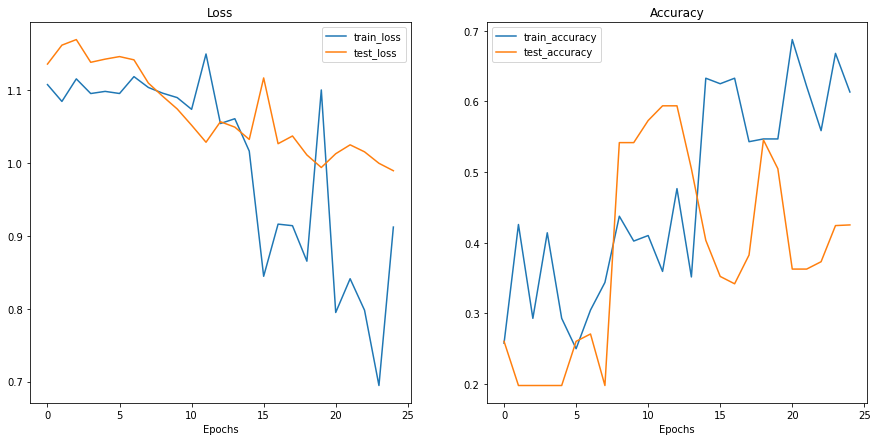

In [47]:
plot_loss_curves(model_0_results)

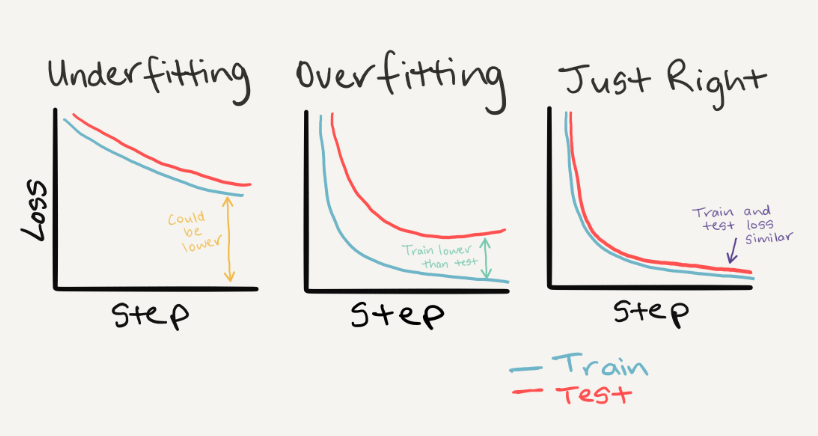

## Dealing with Overfit

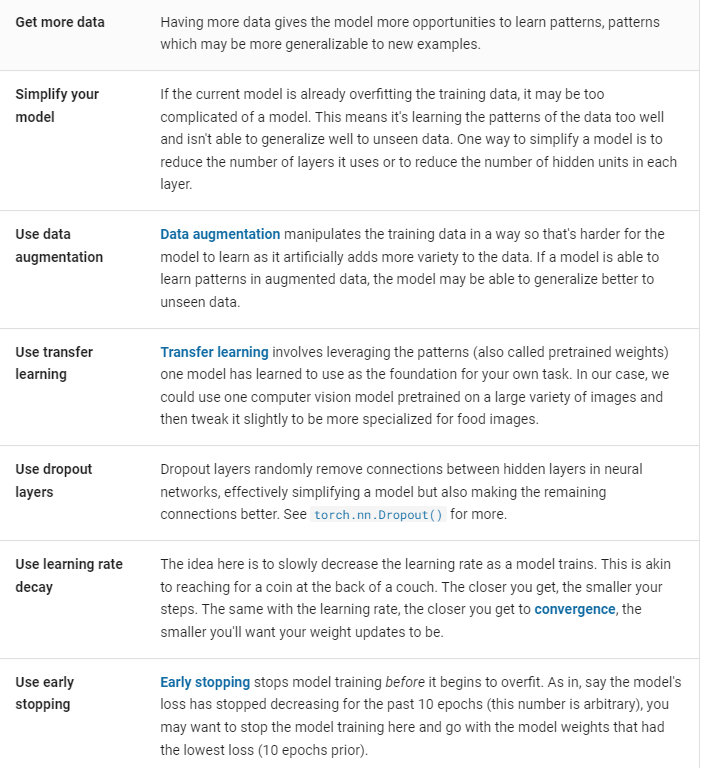

## Dealing with Underfit

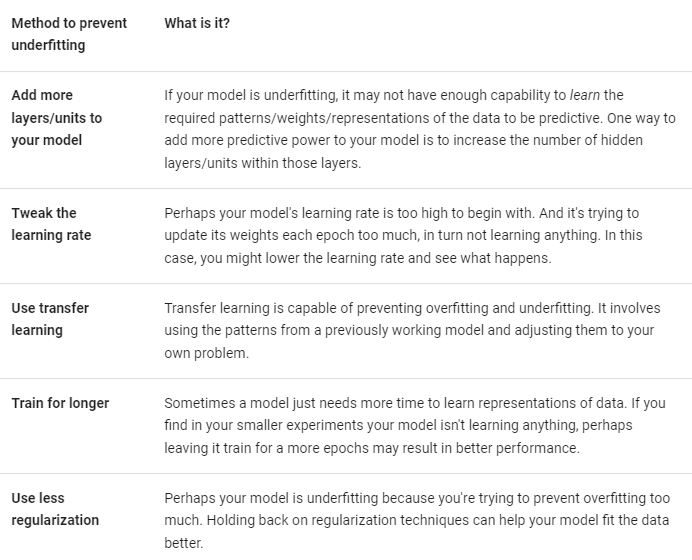

## model_1 with data augmentation

In [48]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [49]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [50]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fbde2513050>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbde3266690>)

In [51]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [52]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  4%|▍         | 1/25 [00:01<00:38,  1.60s/it]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1061 | test_acc: 0.2604


  8%|▊         | 2/25 [00:03<00:34,  1.52s/it]

Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604


 12%|█▏        | 3/25 [00:04<00:32,  1.48s/it]

Epoch: 3 | train_loss: 1.0812 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604


 16%|█▌        | 4/25 [00:05<00:30,  1.46s/it]

Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1627 | test_acc: 0.2604


 20%|██        | 5/25 [00:07<00:29,  1.49s/it]

Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1485 | test_acc: 0.2604


 24%|██▍       | 6/25 [00:09<00:29,  1.53s/it]

Epoch: 6 | train_loss: 1.0968 | train_acc: 0.3047 | test_loss: 1.1456 | test_acc: 0.2604


 28%|██▊       | 7/25 [00:10<00:27,  1.51s/it]

Epoch: 7 | train_loss: 1.0915 | train_acc: 0.4688 | test_loss: 1.1462 | test_acc: 0.1979


 32%|███▏      | 8/25 [00:12<00:28,  1.65s/it]

Epoch: 8 | train_loss: 1.1026 | train_acc: 0.2930 | test_loss: 1.1508 | test_acc: 0.1979


 36%|███▌      | 9/25 [00:15<00:31,  1.95s/it]

Epoch: 9 | train_loss: 1.1209 | train_acc: 0.2930 | test_loss: 1.1494 | test_acc: 0.1979


 40%|████      | 10/25 [00:17<00:32,  2.18s/it]

Epoch: 10 | train_loss: 1.0895 | train_acc: 0.5078 | test_loss: 1.1047 | test_acc: 0.3116


 44%|████▍     | 11/25 [00:20<00:34,  2.46s/it]

Epoch: 11 | train_loss: 1.0754 | train_acc: 0.4609 | test_loss: 1.0808 | test_acc: 0.4735


 48%|████▊     | 12/25 [00:23<00:32,  2.51s/it]

Epoch: 12 | train_loss: 1.0282 | train_acc: 0.5625 | test_loss: 1.0626 | test_acc: 0.4640


 52%|█████▏    | 13/25 [00:26<00:30,  2.53s/it]

Epoch: 13 | train_loss: 1.0363 | train_acc: 0.5547 | test_loss: 1.0578 | test_acc: 0.3826


 56%|█████▌    | 14/25 [00:28<00:26,  2.37s/it]

Epoch: 14 | train_loss: 1.0460 | train_acc: 0.4648 | test_loss: 1.1328 | test_acc: 0.2917


 60%|██████    | 15/25 [00:29<00:20,  2.09s/it]

Epoch: 15 | train_loss: 1.0373 | train_acc: 0.4258 | test_loss: 1.1032 | test_acc: 0.3428


 64%|██████▍   | 16/25 [00:31<00:17,  1.90s/it]

Epoch: 16 | train_loss: 0.9947 | train_acc: 0.5156 | test_loss: 1.1000 | test_acc: 0.3229


 68%|██████▊   | 17/25 [00:32<00:14,  1.77s/it]

Epoch: 17 | train_loss: 1.0820 | train_acc: 0.4336 | test_loss: 1.0587 | test_acc: 0.2917


 72%|███████▏  | 18/25 [00:33<00:11,  1.67s/it]

Epoch: 18 | train_loss: 0.9449 | train_acc: 0.5430 | test_loss: 1.0587 | test_acc: 0.2917


 76%|███████▌  | 19/25 [00:35<00:09,  1.60s/it]

Epoch: 19 | train_loss: 0.9187 | train_acc: 0.5508 | test_loss: 1.0689 | test_acc: 0.3532


 80%|████████  | 20/25 [00:36<00:07,  1.56s/it]

Epoch: 20 | train_loss: 0.9631 | train_acc: 0.4609 | test_loss: 1.0061 | test_acc: 0.4129


 84%|████████▍ | 21/25 [00:38<00:06,  1.53s/it]

Epoch: 21 | train_loss: 0.9491 | train_acc: 0.6094 | test_loss: 0.9718 | test_acc: 0.4223


 88%|████████▊ | 22/25 [00:39<00:04,  1.50s/it]

Epoch: 22 | train_loss: 1.0300 | train_acc: 0.5508 | test_loss: 1.0620 | test_acc: 0.3419


 92%|█████████▏| 23/25 [00:41<00:02,  1.49s/it]

Epoch: 23 | train_loss: 1.0198 | train_acc: 0.4492 | test_loss: 0.9831 | test_acc: 0.4631


 96%|█████████▌| 24/25 [00:42<00:01,  1.46s/it]

Epoch: 24 | train_loss: 0.8930 | train_acc: 0.6133 | test_loss: 1.0426 | test_acc: 0.4754


100%|██████████| 25/25 [00:44<00:00,  1.76s/it]

Epoch: 25 | train_loss: 0.9667 | train_acc: 0.5547 | test_loss: 1.0264 | test_acc: 0.3722
Total training time: 44.019 seconds


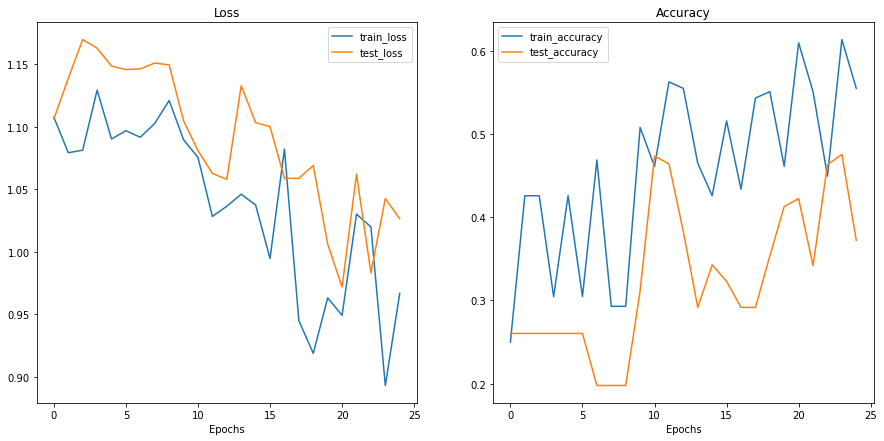

In [53]:
plot_loss_curves(model_1_results)

## Compare results

In [54]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084713,0.425781,1.162010,0.197917
2,1.115687,0.292969,1.169674,0.197917
3,1.095551,0.414062,1.138459,0.197917
4,1.098511,0.292969,1.142803,0.197917
5,1.095601,0.250000,1.146313,0.260417
6,1.118785,0.304688,1.141849,0.270833
7,1.103899,0.343750,1.109941,0.197917
8,1.095995,0.437500,1.091663,0.541667
9,1.089976,0.402344,1.074388,0.541667


In [55]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.107578,0.250000,1.106059,0.260417
1,1.079115,0.425781,1.138691,0.260417
2,1.081169,0.425781,1.169605,0.260417
3,1.129208,0.304688,1.162740,0.260417
4,1.090080,0.425781,1.148469,0.260417
5,1.096750,0.304688,1.145610,0.260417
6,1.091523,0.468750,1.146189,0.197917
7,1.102593,0.292969,1.150843,0.197917
8,1.120860,0.292969,1.149378,0.197917
9,1.089536,0.507812,1.104691,0.311553


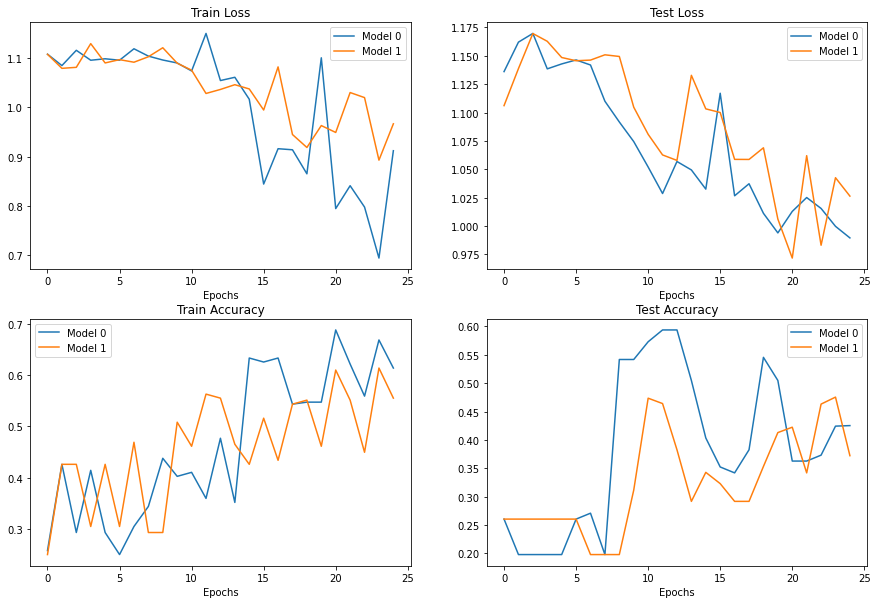

In [56]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [57]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

Since we want to load in an image, we'll use torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [58]:
import torchvision

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

* change the dtype to uint8(0-255) to float32(0-1)

* Our model was trained on images with shape [3, 64, 64], whereas our custom image is currently [3, 4032, 3024].

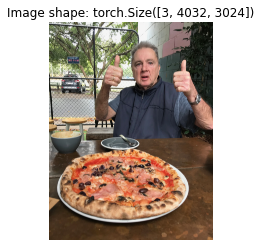

In [59]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [60]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [61]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

### most common error types in pytorch:

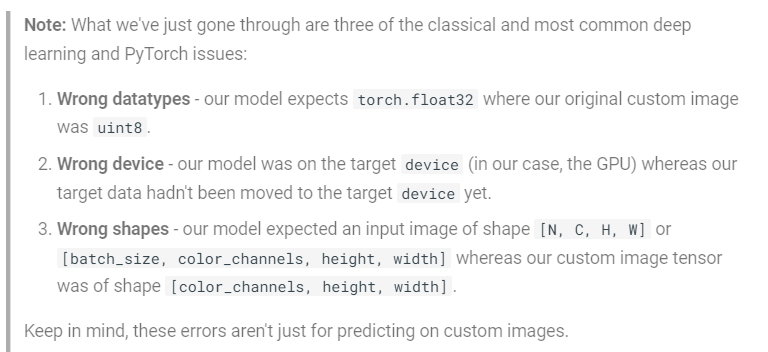

In [62]:
custom_image_pred

tensor([[ 0.4336, -0.6697, -0.2251]], device='cuda:0')

In [63]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.4336, -0.6697, -0.2251]], device='cuda:0')
Prediction probabilities: tensor([[0.5407, 0.1794, 0.2799]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [64]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

* model guessed right but:

Having prediction probabilities this similar could mean a couple of things:

1.   The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2.    The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

### build one function that can be used in a prediction phase that:

1.   Takes in a target image path and converts to the right datatype for our model (torch.float32).
2.   Makes sure the target image pixel values are in the range [0, 1].
3.   Transforms the target image if necessary.
4.   Makes sure the model is on the target device.
5.   Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6.   Converts the model's output logits to prediction probabilities.
7.   Converts the prediction probabilities to prediction labels.
8.   Plots the target image alongside the model prediction and prediction probability.

In [66]:
def pred_and_plot_image(model,image_path,class_names,transform,device):
  
  #load&convert
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image / 255

  #transform
  if transform:
    target_image = transform(target_image)
  
  #pred
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim=0)
    target_image_pred = model(target_image.to(device))

  #logit->probablity->class
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  #change dims order and plot
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else: 
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);




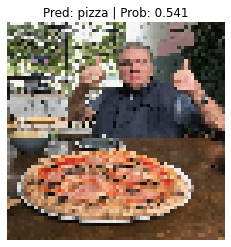

In [67]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)